In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
number_of_class = 6

In [3]:
use_cuda = torch.cuda.is_available()

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
from collections import Counter

class_counter = Counter()
# print(len(train['class']))
class_names =['class_' + str(i) for i in range(number_of_class)]
for class_name in class_names:
    class_counter[class_name] = 0
for i in train['class']:
    class_counter['class_' + str(i)] += 1

print(class_counter)

max_count = -np.Inf
for i in range(number_of_class):
    if class_counter['class_' + str(i)] > max_count:
        max_count = class_counter['class_' + str(i)]

train_classified = [train[train['class'] == i] for i in range(number_of_class)]

for i in range(number_of_class):
    num_need_resample = max_count - class_counter['class_' + str(i)]
    num_resample_batch = num_need_resample // class_counter['class_' + str(i)]
    num_resample_leftover = num_need_resample % class_counter['class_' + str(i)]
    for j in range(num_resample_batch):
        add_df = train_classified[i]
        train =  pd.concat([train, add_df[0:dist_class[i][1]]], ignore_index=True)
        train =  train.append(df_to_be_added)
        

    df_to_be_added = train_classified[i][:num_resample_leftover]
    print('df to be added:', df_to_be_added.shape)
    train =  train.append(df_to_be_added)
    print(train.shape)
    

Counter({'class_0': 1611, 'class_2': 1478, 'class_5': 1411, 'class_1': 920, 'class_3': 889, 'class_4': 851})
df to be added: (0, 184)
(7160, 184)
df to be added: (691, 184)
(7851, 184)
df to be added: (133, 184)
(7984, 184)
df to be added: (722, 184)
(8706, 184)
df to be added: (760, 184)
(9466, 184)
df to be added: (200, 184)
(9666, 184)


In [6]:
class_names =[i for i in range(number_of_class)]
for class_name in class_names:
    class_counter[class_name] = 0
for i in train['class']:
    class_counter[i] += 1

class_counter.most_common(number_of_class)

[('class_0', 1611), (0, 1611), (1, 1611), (2, 1611), (3, 1611), (4, 1611)]

In [7]:
all_data = pd.concat((train.loc[:,'appearedTimeOfDay':'cooc_151'],
                      test.loc[:,'appearedTimeOfDay':'cooc_151']))
id = test['id']

In [8]:
all_data.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,19,10,13,False,Bangkok,Asia,Clear,27.8,9.00,...,False,False,False,False,False,False,False,False,False,False
1,night,5,19,13,True,New_York,America,Clear,26.1,8.70,...,False,False,False,False,False,False,False,False,False,False
2,evening,19,46,0,True,New_York,America,Clear,24.7,16.82,...,False,False,False,False,False,False,False,False,False,False
3,morning,11,10,0,True,Hobart,Australia,Clear,12.7,13.25,...,False,False,False,False,False,False,False,False,False,False
4,evening,18,32,13,True,Los_Angeles,America,PartlyCloudy,19.1,5.78,...,False,False,False,False,False,False,False,False,False,False


In [9]:
all_data = all_data.applymap(lambda x: 1.0 if x == True else x)
all_data = all_data.applymap(lambda x: 0.0 if x == False else x)
all_data = pd.get_dummies(all_data)
# numeric_feats = df.dtypes[df.dtypes != "object"].index
# df = df[numeric_feats]
apearedHour = all_data['appearedHour']
appearedMinute = all_data['appearedMinute']
appearedTimeDayCycle = apearedHour * 60 + appearedMinute
appearedTimeDayCycle = np.sin(appearedTimeDayCycle / (24 * 60) * 2 * np.pi)
# print('appearedTimeDayCycle= ',appearedTimeDayCycle)
all_data = all_data.drop(['appearedHour'], axis=1)
all_data = all_data.drop(['appearedMinute'], axis=1)
all_data['appearedTimeDayCycle'] = appearedTimeDayCycle

# df = df.drop(['temperature'], axis=1)
# df = df.drop(['windSpeed'], axis=1)
# df = df.drop(['pressure'], axis=1)
# df = df.drop(['gymIn100m'], axis=1)
# df = df.drop(['gymIn250m'], axis=1)
# df = df.drop(['gymIn500m'], axis=1)
# df = df.drop(['gymIn1000m'], axis=1)
# df = df.drop(['gymIn2500m'], axis=1)
# df = df.drop(['gymIn5000m'], axis=1)
# df = df.drop(['rural'], axis=1)
# df = df.drop(['midurban'], axis=1)
# df = df.drop(['suburban'], axis=1)
# df = df.drop(['urban'], axis=1)
# df = df.drop(['pokestopIn100m'], axis=1)
# df = df.drop(['pokestopIn250m'], axis=1)
# df = df.drop(['pokestopIn500m'], axis=1)
# df = df.drop(['pokestopIn1000m'], axis=1)
# df = df.drop(['pokestopIn2500m'], axis=1)
# df = df.drop(['pokestopIn5000m'], axis=1)
# df = df.drop(['terrainType'], axis=1)
# df = df.drop(['closeToWater'], axis=1)


In [10]:
all_data.head()

,terrainType,closeToWater,temperature,windSpeed,pressure,population_density,urban,suburban,midurban,rural,...,weather_WindyandPartlyCloudy,weatherIcon_clear-day,weatherIcon_clear-night,weatherIcon_cloudy,weatherIcon_fog,weatherIcon_partly-cloudy-day,weatherIcon_partly-cloudy-night,weatherIcon_rain,weatherIcon_wind,appearedTimeDayCycle
0,13.0,0.0,27.8,9.00,1008.96,6019.04440,1.0,1.0,1.0,0.0,...,0,1,0,0,0,0,0,0,0,-0.953717
1,13.0,1.0,26.1,8.70,1018.96,0.00000,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0.984041
2,0.0,1.0,24.7,16.82,1023.22,0.00000,0.0,0.0,0.0,1.0,...,0,1,0,0,0,0,0,0,0,-0.894934
3,0.0,1.0,12.7,13.25,1014.19,128.89505,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0.216440
4,13.0,1.0,19.1,5.78,1011.36,4188.39100,1.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,-0.990268


In [11]:
# list(all_data.columns.values)

In [12]:
#let's look at the data :
# matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# data = pd.DataFrame({"x":df['population_density'], "y":targets})

# data.plot(x = "x", y = "y",kind = "scatter")

In [13]:
#normailize to 0-1
for k in all_data.columns.values:
    if (all_data[k].max() - all_data[k].min()) > 0:
        all_data[k] = (all_data[k] - all_data[k].min())/(all_data[k].max() - all_data[k].min())
    else:
        all_data[k] = 0

In [14]:
all_data.head()

,terrainType,closeToWater,temperature,windSpeed,pressure,population_density,urban,suburban,midurban,rural,...,weather_WindyandPartlyCloudy,weatherIcon_clear-day,weatherIcon_clear-night,weatherIcon_cloudy,weatherIcon_fog,weatherIcon_partly-cloudy-day,weatherIcon_partly-cloudy-night,weatherIcon_rain,weatherIcon_wind,appearedTimeDayCycle
0,0.8125,0.0,0.631868,0.160342,0.333774,0.601904,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023142
1,0.8125,1.0,0.585165,0.154997,0.598044,0.000000,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.992020
2,0.0000,1.0,0.546703,0.299662,0.710624,0.000000,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.052533
3,0.0000,1.0,0.217033,0.236059,0.471987,0.012890,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608220
4,0.8125,1.0,0.392857,0.102975,0.397199,0.418839,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004866


In [15]:
features = all_data[:train.shape[0]]
features_test = all_data[train.shape[0]:]
targets = train['class']

features.info()
features.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9666 entries, 0 to 1088
Columns: 297 entries, terrainType to appearedTimeDayCycle
dtypes: float64(272), int64(25)
memory usage: 22.0 MB


(9666, 297)

(array([1611.,    0., 1611.,    0., 1611.,    0., 1611.,    0., 1611.,
        1611.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

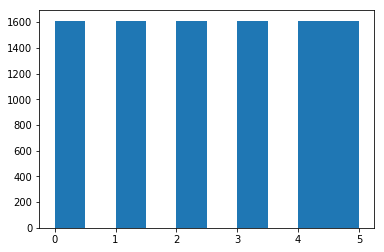

In [16]:
plt.hist(targets)

In [17]:
from sklearn.model_selection import train_test_split

train_ratio = 0.9
test_ratio = 0.2
# split the data into training and validation sets

X_train, X_valid, y_train, y_valid = train_test_split(features.values, targets.values, test_size = 1 - train_ratio, stratify=targets.values, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = test_ratio, stratify=y_valid, random_state=0)
X_train.shape,X_valid.shape,X_test.shape

((8699, 297), (773, 297), (194, 297))

train_ratio = 0.98

test_ratio = 0.2

(array([32.,  0., 32.,  0., 32.,  0., 32.,  0., 33., 33.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

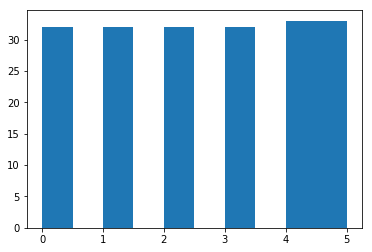

In [18]:
plt.hist(y_test)
# plt.hist(y_valid)
# plt.hist(y_train)

In [19]:
print(type(y_train))

<class 'numpy.ndarray'>


In [20]:
import torch.utils.data as data_utils

data_train = data_utils.TensorDataset(torch.from_numpy(X_train).type((torch.FloatTensor)), torch.from_numpy(y_train).type((torch.LongTensor)))
data_valid = data_utils.TensorDataset(torch.from_numpy(X_valid).type((torch.FloatTensor)), torch.from_numpy(y_valid).type((torch.LongTensor)))
data_test = data_utils.TensorDataset(torch.from_numpy(X_test).type((torch.FloatTensor)), torch.from_numpy(y_test).type((torch.LongTensor)))

In [21]:
# how many data per batch to load
batch_size = 10000

# convert data to torch.FloatTensor

loaders = {}
loaders['train'] = torch.utils.data.DataLoader(data_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

loaders['valid'] = torch.utils.data.DataLoader(data_valid,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)
loaders['test'] = torch.utils.data.DataLoader(data_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)

In [22]:
# for batch_idx, (data, target) in enumerate(loaders['train']):
#     print(target)

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(297, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 6)
        self.dropout = nn.Dropout(0.3)




    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))


        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model = Net()
def init_weights(m):
        print(m)
        if type(m) == nn.Linear:
            m.weight.data.fill_(1.0)
            print(m.weight)
            
def init_ortho(m):
    print()
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)
        print(m.weight)

# use the modules apply function to recursively apply the initialization
# model.apply(init_ortho)

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

In [24]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer

optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.Adamax(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01,weight_decay= 1e-6, momentum = 0.9, nesterov = True)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [25]:
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        start = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

#             data = data.type((torch.FloatTensor))

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update accumulated training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
#             data = data.type((torch.FloatTensor))
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update accumulated validation loss 
            valid_loss += loss.item()*data.size(0)
            

        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t time: {:.1f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time.time() - start
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased from {:.6f} to {:.6f}. Model was saved'.format(
                valid_loss_min,
                valid_loss
            ))
            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model


# train the model
model = train(2200, loaders, model, optimizer, 
                      criterion, use_cuda, 'model.pt')

/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.794868 	Validation Loss: 1.791257 	 time: 0.3
Validation loss decreased from inf to 1.791257. Model was saved
Epoch: 2 	Training Loss: 1.793078 	Validation Loss: 1.791187 	 time: 0.2
Validation loss decreased from 1.791257 to 1.791187. Model was saved
Epoch: 3 	Training Loss: 1.791942 	Validation Loss: 1.790441 	 time: 0.2
Validation loss decreased from 1.791187 to 1.790441. Model was saved
Epoch: 4 	Training Loss: 1.791087 	Validation Loss: 1.789143 	 time: 0.3
Validation loss decreased from 1.790441 to 1.789143. Model was saved
Epoch: 5 	Training Loss: 1.789765 	Validation Loss: 1.787500 	 time: 0.2
Validation loss decreased from 1.789143 to 1.787500. Model was saved
Epoch: 6 	Training Loss: 1.787651 	Validation Loss: 1.785343 	 time: 0.3
Validation loss decreased from 1.787500 to 1.785343. Model was saved
Epoch: 7 	Training Loss: 1.785821 	Validation Loss: 1.782363 	 time: 0.3
Validation loss decreased from 1.785343 to 1.782363. Model was saved
Epoch: 8 	T

Epoch: 215 	Training Loss: 1.329372 	Validation Loss: 1.419149 	 time: 0.4
Epoch: 216 	Training Loss: 1.328865 	Validation Loss: 1.416587 	 time: 0.4
Validation loss decreased from 1.417114 to 1.416587. Model was saved
Kaggle score = 0.54438 (0.0006 IMPROVEMENT)

Epoch: 216 	Training Loss: 1.326797 	Validation Loss: 1.396590 	 time: 0.7
Epoch: 217 	Training Loss: 1.326093 	Validation Loss: 1.396514 	 time: 0.7
Epoch: 218 	Training Loss: 1.325473 	Validation Loss: 1.394434 	 time: 0.6
Validation loss decreased from 1.396026 to 1.394434. Model was saved
Kaggle score = 55245 (0.011 IMPROVEMENT)

Epoch: 364 	Training Loss: 1.229904 	Validation Loss: 1.381198 	 time: 0.3
Validation loss decreased from 1.384373 to 1.381198. Model was saved
Epoch: 365 	Training Loss: 1.231026 	Validation Loss: 1.394960 	 time: 0.3
Epoch: 366 	Training Loss: 1.231521 	Validation Loss: 1.379200 	 time: 0.3
Validation loss decreased from 1.381198 to 1.379200. Model was saved
Epoch: 367 	Training Loss: 1.232151 	Validation Loss: 1.395807 	 time: 0.3
Epoch: 368 	Training Loss: 1.230561 	Validation Loss: 1.391226 	 time: 0.3


In [26]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
#         data = data.type((torch.FloatTensor))
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))
# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 1.348660


Test Accuracy: 60% (118/194)


/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [27]:
i,l = next(iter(loaders['test']))
if use_cuda:
    i, l = i.cuda(), l.cuda()

output = model(i)

result = output.cpu().data.max(1, keepdim=True)[1].numpy()
result[:,0]

/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([0, 3, 1, 5, 3, 1, 2, 5, 1, 1, 3, 1, 3, 5, 5, 3, 5, 5, 0, 3, 5, 5,
       2, 5, 0, 3, 3, 1, 5, 5, 3, 2, 2, 5, 3, 2, 3, 5, 0, 0, 1, 3, 2, 3,
       5, 5, 1, 5, 0, 0, 2, 5, 0, 0, 3, 3, 0, 3, 0, 1, 1, 1, 3, 3, 3, 3,
       5, 5, 3, 3, 2, 0, 2, 1, 2, 1, 0, 0, 3, 5, 3, 5, 3, 3, 0, 0, 3, 2,
       3, 5, 5, 3, 2, 3, 5, 5, 1, 3, 5, 3, 2, 5, 3, 3, 3, 1, 5, 5, 1, 3,
       5, 5, 1, 5, 5, 3, 3, 3, 3, 5, 5, 3, 5, 3, 2, 3, 3, 3, 3, 0, 1, 1,
       5, 3, 2, 2, 3, 0, 2, 0, 5, 0, 3, 3, 0, 2, 3, 2, 0, 3, 3, 5, 2, 1,
       1, 0, 5, 1, 3, 5, 1, 0, 0, 1, 0, 2, 0, 2, 2, 5, 2, 2, 0, 5, 3, 3,
       3, 2, 0, 3, 3, 1, 0, 3, 3, 5, 3, 3, 1, 5, 1, 0, 2, 1])

(array([31.,  0., 28.,  0., 27.,  0., 63.,  0.,  0., 45.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

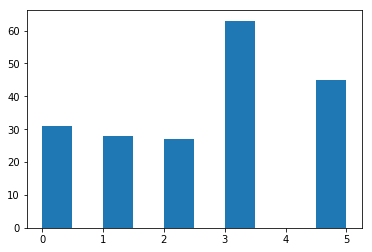

In [28]:
d = result[:,0]
plt.hist(d)

(array([32.,  0., 32.,  0., 32.,  0., 32.,  0., 33., 33.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

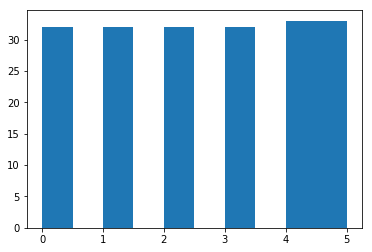

In [29]:
plt.hist(l.cpu().numpy())

In [30]:
features_test_data = torch.tensor(features_test.values).type((torch.FloatTensor))
if use_cuda:
    features_test_data = features_test_data.cuda()
predicted_class = model(features_test_data)
# We will look at the predicted prices to ensure we have something sensible.
predicted_class = predicted_class.data.cpu().max(1, keepdim=True)[1].numpy()[:,0]
predicted_class

/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([2, 1, 3, ..., 1, 2, 1])

In [31]:
solution = pd.DataFrame({"ID":id, "class":predicted_class})
solution.to_csv("pokemon_sol.csv", index = False)